In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa
from keras.layers import Flatten, Dense, Dropout
import tifffile

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

import os

import scipy

2023-03-14 03:21:17.607518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 03:21:17.834017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 03:21:17.834046: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-14 03:21:20.145257: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# !pip install numpy tensorflow matplotlib scipy
# !pip install pandas
# !pip install tifffile
# !pip install scikit-learn
# !pip install imagecodecs
# !pip install tensorflow-addons

In [3]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

In [4]:
tiles = pd.read_csv(r'Data/Tiles_expanded.csv')
tiles_expanded_rv = pd.read_csv(r'Data/Tiles_expanded_road_vector.csv').drop(['Unnamed: 0'],axis=1)
tiles_expanded_rv = pd.get_dummies(tiles_expanded_rv, columns = ['RTTYP'])

In [5]:
tiles_expanded_rv.head()

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0


In [6]:
tiles_expanded_rv['Collisions_Future_binary']=tiles_expanded_rv['Collisions_Future'].apply(lambda x: 1 if x > 0 else 0)
tiles_expanded_rv['Collisions_Historical_binary']=tiles_expanded_rv['Collisions_Historical'].apply(lambda x: 1 if x > 0 else 0)

In [7]:
tiles_binned = pd.read_csv(r'Data/Tiles_binned.csv')
tiles_binned.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,bin
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0


# Normalize data

In [8]:
def normalize_col(df, col_name):

    norm = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return norm

tiles_expanded_rv['Mid_lat_norm'] = normalize_col(tiles_expanded_rv,'Mid_lat')
tiles_expanded_rv['Mid_long_norm'] = normalize_col(tiles_expanded_rv,'Mid_long')


Split into training and test

In [9]:
MODEL_TYPE='logistic' # 'linear'

if MODEL_TYPE == 'linear':
    input_x = ['Tile_ID','Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']
    input_y = tiles_expanded_rv['Collisions_Future']
elif MODEL_TYPE == 'logistic':
    input_x = ['Tile_ID','Collisions_Historical_binary', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']
    input_y = ['Collisions_Future_binary']
    

x_train, x_test, y_train, y_test = train_test_split(
                                    tiles_expanded_rv[input_x], 
                                    tiles_expanded_rv[input_y],
                                    random_state=104, 
                                    test_size=0.20, 
                                    shuffle=True)



In [10]:
# np.asarray(x_train[['Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']]).astype('float32').shape

Model #1: Linear regression using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates

## Image Pre-Processing

In [11]:
IMAGE_PATH = 'Satellite Imagery/Satellite Images Tiled/' 

In [12]:
#eda
img = tifffile.imread('Satellite Imagery/Satellite Images Tiled/36.tif')[0:148, 0:188, :]
img2 = tifffile.imread('Satellite Imagery/Satellite Images Tiled/37.tif')[0:148, 0:188, :]

In [13]:
# eda
print(np.shape(img2))

(148, 188, 4)


In [14]:
# eda
test = []
test.append(img[0:148, 0:188, :])
test.append(img2[0:148, 0:188, :])
print(np.shape(test))
test = np.stack(test)
print(np.shape(test))

(2, 148, 188, 4)
(2, 148, 188, 4)


In [15]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

images_mini = preprocess_data_part1(IMAGE_PATH)

In [16]:
# THERE IS ONE FILE IN THE "SATELLITE IMAGES TILED" FOLDER THAT IS NOT A TIF IMAGE, DELETE THIS FILE
images_mini = preprocess_data_part1(IMAGE_PATH)

In [17]:
np.shape(images_mini)

(8376, 148, 188, 4)

In [18]:
# images_mini_reshaped = images_mini.reshape((8376,1,1,111296))

In [19]:
# images_mini_reshaped.shape
# len(images_mini_reshaped[0][0][0])

Street Data Pre-Processing

In [20]:
street = np.asarray(x_train[input_x[1:]]).astype('float32')
street_mini = []
for row in street:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 11)

In [21]:
input_image_street = np.hstack(
    (street_mini.reshape((8376,11)),
     images_mini.reshape(8376,111296))
)

In [22]:
# input_image_street = input_image_street.reshape((8376,1,1, 111307))

In [23]:
input_image_street.shape
# y_train.shape

(8376, 111307)

## Linear Regression

ARISA START

In [24]:
tiles_down = pd.read_csv(r'Data/Tiles_no_binning_downsampled.csv')
tiles_down.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U
0,266,-122.512166,37.779636,-122.511026,37.778732,37.779184,-122.511596,1.0,0.0,0.0,0.0,5.0,5.0,0,1,0,0,0
1,271,-122.512166,37.775118,-122.511026,37.774214,37.774666,-122.511596,4.0,0.0,0.0,0.0,1.0,3.0,0,1,0,0,0
2,275,-122.512166,37.771503,-122.511026,37.770600,37.771052,-122.511596,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0
3,390,-122.511026,37.771503,-122.509885,37.770600,37.771052,-122.510456,0.0,0.0,0.0,1.0,1.0,1.0,0,1,0,0,0
4,391,-122.511026,37.770600,-122.509885,37.769696,37.770148,-122.510456,0.0,0.0,0.0,0.0,2.0,4.0,0,1,0,0,0


In [25]:
x_train, x_test, y_train, y_test = train_test_split(
                                    tiles_down[['Tile_ID','Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']], 
                                    tiles_down['Collisions_Future'],
                                    random_state=104, 
                                    test_size=0.20, 
                                    shuffle=True)

In [26]:
IMAGE_PATH = 'Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

images_mini = preprocess_data_part1(IMAGE_PATH)

In [27]:
street = np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']]).astype('float32')
street_mini = []
for row in street:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(2592, 1, 1, 11)

In [28]:
input_image_street = np.hstack(
    (street_mini.reshape((len(x_train),11)),
     images_mini.reshape(len(x_train),111296))
)

In [29]:
input_image_street.shape

(2592, 111307)

In [30]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U'
# y: 'Collisions_Future'

def create_linear_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(111307,))

    outputs = layers.Dense(1)(input)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error'
        )
    
    return linear_model

linear_model = create_linear_model()

history = linear_model.fit(
    input_image_street,
     np.stack(y_train),
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111307)]          0         
                                                                 
 dense (Dense)               (None, 1)                 111308    
                                                                 
Total params: 111,308
Trainable params: 111,308
Non-trainable params: 0
_________________________________________________________________


2023-03-14 03:23:19.696778: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 03:23:19.696815: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 03:23:19.696842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-82-179): /proc/driver/nvidia/version does not exist
2023-03-14 03:23:19.697085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
65/65 [==============================] - 1s 9ms/step - loss: 12590782.0000 - val_loss: 163407.9844
Epoch 2/10
65/65 [==============================] - 0s 6ms/step - loss: 29324.0703 - val_loss: 8324.6221
Epoch 3/10
65/65 [==============================] - 0s 6ms/step - loss: 8689.9062 - val_loss: 5133.0376
Epoch 4/10
65/65 [==============================] - 0s 6ms/step - loss: 6388.9546 - val_loss: 4494.4326
Epoch 5/10
65/65 [==============================] - 0s 6ms/step - loss: 4540.4263 - val_loss: 3698.4192
Epoch 6/10
65/65 [==============================] - 0s 6ms/step - loss: 4831.9150 - val_loss: 4360.5640
Epoch 7/10
65/65 [==============================] - 0s 6ms/step - loss: 3987.3464 - val_loss: 3331.1736
Epoch 8/10
65/65 [==============================] - 0s 7ms/step - loss: 3404.6792 - val_loss: 2800.7317
Epoch 9/10
65/65 [==============================] - 0s 6ms/step - loss: 3060.3896 - val_loss: 4121.9312
Epoch 10/10
65/65 [==============================] - 0s 6

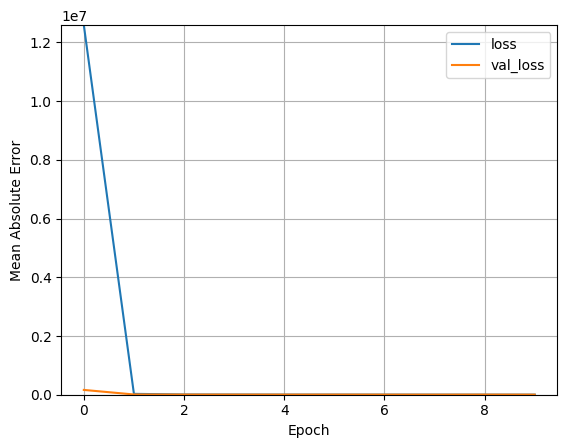

In [31]:
plot_loss(history)

In [32]:
test_lin = linear_model.predict(input_image_street)

81/81 [==============================] - 0s 3ms/step


In [33]:
print(test_lin)

[[ 60.3189  ]
 [-22.727474]
 [ -8.36577 ]
 ...
 [ 16.632961]
 [-26.020763]
 [ 83.712776]]


(array([ 30., 134., 496., 880., 696., 273.,  73.,   8.,   1.,   1.]),
 array([-126.70069885,  -89.2846756 ,  -51.86865616,  -14.45263386,
          22.96338844,   60.37940979,   97.79543304,  135.2114563 ,
         172.62747192,  210.04350281,  247.45951843]),
 <BarContainer object of 10 artists>)

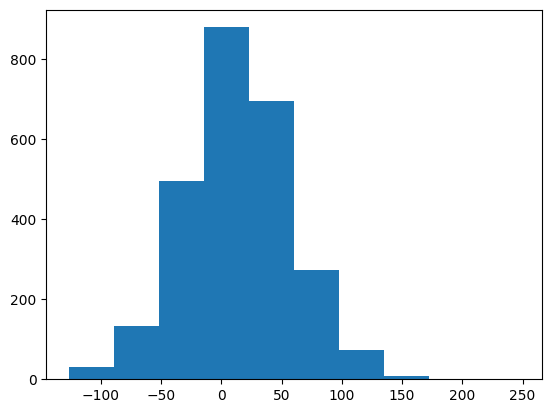

In [34]:
plt.hist(test_lin)

## LOGISTIC MODEL WITH IMAGES

ARISA START

In [35]:
tiles_binned = pd.read_csv(r'Data/Tiles_binned.csv')
tiles_binned.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,bin
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0


In [36]:
x_train, x_test, y_train, y_test = train_test_split(
                                    tiles_binned[['Tile_ID','Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']], 
                                    tiles_binned['bin'],
                                    random_state=104, 
                                    test_size=0.20, 
                                    shuffle=True)

In [37]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

images_mini = preprocess_data_part1(IMAGE_PATH)

In [38]:
street = np.asarray(x_train[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']]).astype('float32')
street_mini = []
for row in street:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 11)

In [39]:
input_image_street = np.hstack(
    (street_mini.reshape((len(x_train),11)),
     images_mini.reshape(len(x_train),111296))
)

In [40]:
input_image_street.shape

(8376, 111307)

In [41]:
y_train.shape

(8376,)

In [42]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

(array([6.644e+03, 1.201e+03, 2.830e+02, 1.340e+02, 6.100e+01, 2.600e+01,
        1.400e+01, 5.000e+00, 4.000e+00, 4.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

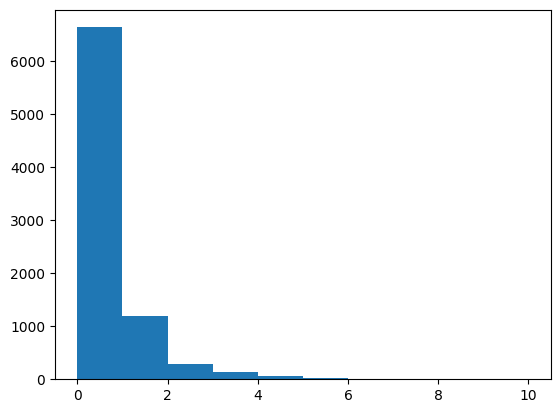

In [72]:
plt.hist(y_train)

In [43]:
y_train_2 = []
for row in y_train:
    y_train_2.append([row])
y_train_2 = np.stack(y_train_2)
np.shape(y_train_2)

(8376, 1)

Model: "logistic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 111307)]          0         
                                                                 
 dense_10 (Dense)            (None, 11)                1224388   
                                                                 
Total params: 1,224,388
Trainable params: 1,224,388
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
53/53 [==============================] - 1s 12ms/step - loss: 237270.5156 - accuracy: 0.2834 - val_loss: 161.6378 - val_accuracy: 0.1599
Epoch 2/10
53/53 [==============================] - 0s 9ms/step - loss: 80496.0469 - accuracy: 0.3192 - val_loss: 71.0643 - val_accuracy: 0.4368
Epoch 3/10
53/53 [==============================] - 1s 10ms/step - loss: 64300.0781 - accuracy: 0.3622 - val_loss: 131.3926 - val_accuracy: 0.389

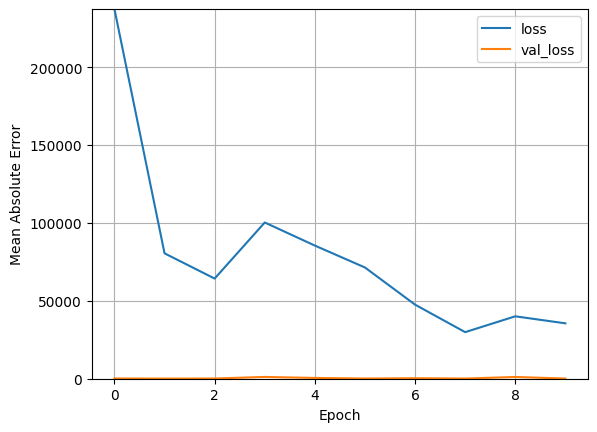

In [97]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U'
# y: 'Collisions_Future'

def create_logistic_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(111307,))
    
    input = keras.layers.Flatten()(input)

    outputs = keras.layers.Dense(units = 11, activation = 'softmax')(input)

    logistic_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="logistic_model")

    logistic_model.summary()

    logistic_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=["sparse_categorical_crossentropy"],
        metrics=['accuracy']
        )
    
    return logistic_model

logistic_model = create_logistic_model()

class_weight = {0: 100,
                1: 1000,
                2: 1000,
                3: 1000,
                4: 1000,
                5: 1000,
                6: 1000,
                7: 1000,
                8: 1000,
                9: 1000,
                10: 1000,
                #11: 100000,
               }

history = logistic_model.fit(
    input_image_street,
     y_train_2,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

plot_loss(history)

In [92]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

images_mini = preprocess_data_part1(IMAGE_PATH)

street = np.asarray(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']]).astype('float32')
street_mini = []
for row in street:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

input_image_street_2 = np.hstack(
    (street_mini.reshape((len(x_test),11)),
     images_mini.reshape(len(x_test),111296))
)

In [98]:
test = logistic_model.predict(input_image_street_2)

66/66 [==============================] - 0s 3ms/step


In [99]:
test_values = []
for i in test: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    test_values.append(index[0])

(array([1.552e+03, 3.940e+02, 5.300e+01, 0.000e+00, 9.000e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 5.000e+00, 1.000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

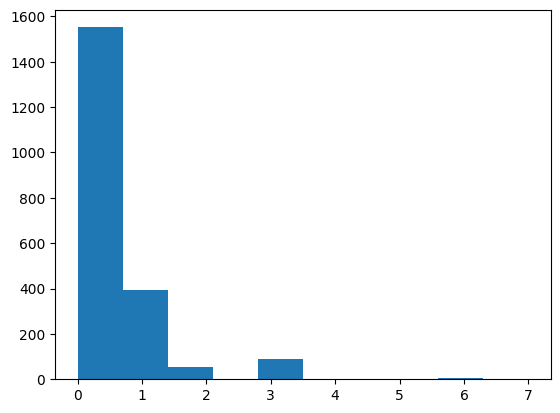

In [100]:
plt.hist(test_values)

(array([1.646e+03, 3.040e+02, 7.200e+01, 4.300e+01, 1.100e+01, 1.000e+01,
        4.000e+00, 2.000e+00, 2.000e+00, 1.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

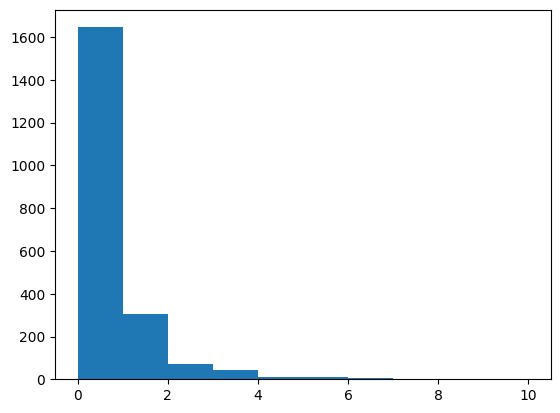

In [101]:
plt.hist(y_test)

ARISA END

Aditya's Work

In [49]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

log_reg = LogisticRegression()

def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

In [50]:
y_pred = log_reg(input_image_street[2000:2155], train=False)
y_pred.numpy()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [51]:
batch_size = 2 #  64
train_dataset = tf.data.Dataset.from_tensor_slices((input_image_street, y_train))
train_dataset = train_dataset.shuffle(buffer_size=input_image_street.shape[0]).batch(batch_size)
# test_dataset = tf.data.Dataset.from_tensor_slices((input_image_street, y_test))
# test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

ValueError: Dimensions 2095 and 8376 are not compatible

In [ ]:
# Set training parameters
epochs = 3 # 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")